In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
import cmocean

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Cosine-Lanczos filter

In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [3]:
#vtools gap.py
#https://github.com/CADWRDeltaModeling/vtools3/blob/master/vtools/data/gap.py
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from enum import Enum, auto
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Tuple

__all__ = ["gap_count", "gap_size", "gap_distance"]


def gap_count(ts, state="gap", dtype=int):
    """Count missing data
    Identifies gaps (runs of missing or non-missing data) and quantifies the
    length of the gap in terms of number of samples, which works better for
    regular series. Each time point receives the length of the run.

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`
        Time series to analyze

    state : `str` one of 'gap'|'good'|'both'
        State to count. If state is gap, block size of missing data are counted
        and reported for time points in the gap (every point in a given gap will
        receive the same value). Non missing data will have a size of zero.
        Setting state to 'good' inverts this -- missing blocks are reported as
        zero and good data are counted.

    dtype : `str` or `type`
        Data type of output, should be acceptable to
        pandas :meth:`astype <pandas:pandas.DataFrame.astype>`

    """

    def column_gap_count(ser):
        s = ser.index.to_series()
        tsout = ser.fillna(0).astype(dtype)
        miss = ser.isna()
        # create consecutive groups that increment each time the "is missing state" (na or not na) changes
        g = miss.ne(miss.shift()).cumsum()

        # identify beginning (min time) of each state
        count = s.groupby(g).count()

        # g contains a group index for each member of out, and here
        # we map g to out which has cumulative time
        tsout = g.map(count)
        if state == "gap":
            tsout.loc[~miss] = 0
        elif state == "good":
            tsout.loc[miss] = 0
        return tsout

    if hasattr(ts, "columns"):
        return ts.apply(column_gap_count, axis=0, result_type="broadcast").astype(dtype)
    else:
        return column_gap_count(ts).astype(dtype)


def gap_size(ts):
    """
    Identifies gaps (runs of missing data) and quantifies the
    length of the gap. Each time point receives the length of the run
    in terms of seconds or number of values in the time dimension,
    with non-missing data returning zero. Time is measured from the time the
    data first started being missing to when the data first starts being not missing
    .

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`

    Returns
    -------
    result : :class:`DataFrame <pandas:pandas.DataFrame>`
        A new regular time series with the same freq as the argument
        holding the size of the gap.

    Examples
    --------
    >>> ndx = pd.date_range(pd.Timestamp(2017,1,1,12),freq='15min',periods=10)
    >>> vals0 = np.arange(0.,10.,dtype='d')
    >>> vals1 = np.arange(0.,10.,dtype='d')
    >>> vals2 =  np.arange(0.,10.,dtype='d')
    >>> vals0[0:3] = np.nan
    >>> vals0[7:-1] = np.nan
    >>> vals1[2:4] = np.nan>>>
    >>> vals1[6] = np.nan
    >>> vals1[9] = np.nan

    >>> df = pd.DataFrame({'vals0':vals0,'vals1':vals1,'vals2':vals2},index = ndx)
    >>> out = gap_size(df)
    >>> print(df)
                             vals0  vals1  vals2
    2017-01-01 12:00:00    NaN    0.0    0.0
    2017-01-01 12:15:00    NaN    1.0    1.0
    2017-01-01 12:30:00    NaN    NaN    2.0
    2017-01-01 12:45:00    3.0    NaN    3.0
    2017-01-01 13:00:00    4.0    4.0    4.0
    2017-01-01 13:15:00    5.0    5.0    5.0
    2017-01-01 13:30:00    6.0    NaN    6.0
    2017-01-01 13:45:00    NaN    7.0    7.0
    2017-01-01 14:00:00    NaN    8.0    8.0
    2017-01-01 14:15:00    9.0    NaN    9.0
    >>> print(out)
                             vals0  vals1  vals2
    2017-01-01 12:00:00   45.0    0.0    0.0
    2017-01-01 12:15:00   45.0    0.0    0.0
    2017-01-01 12:30:00   45.0   30.0    0.0
    2017-01-01 12:45:00    0.0   30.0    0.0
    2017-01-01 13:00:00    0.0    0.0    0.0
    2017-01-01 13:15:00    0.0    0.0    0.0
    2017-01-01 13:30:00    0.0   15.0    0.0
    2017-01-01 13:45:00   30.0    0.0    0.0
    2017-01-01 14:00:00   30.0    0.0    0.0
    2017-01-01 14:15:00    0.0    0.0    0.0

    """

    ts_out = ts * 0.0

    s = ts.index.to_series()
    for c in ts.columns:
        # test missing values
        miss = ts[c].isna()
        # create consecutive groups that increment each time the "is missing state" (na or not na) changes
        g = miss.ne(miss.shift()).cumsum()
        # identify beginning (min time) of each state
        m1 = s.groupby(g).min()

        # get beginning of next groups, last value is replaced last value of index
        m2 = m1.shift(-1).fillna(ts.index[-1])

        # get difference, convert to minutes
        diffs = m2.sub(m1).dt.total_seconds().div(60).astype(int)

        # g contains a group index for each member of out, and here
        # we map g to out which has cumulative time
        ts_out[c] = g.map(diffs)
        ts_out.loc[~miss, c] = 0.0
    return ts_out


def gap_distance(ts, disttype="count", to="good"):
    """
    For each element of ts, count the distance to the nearest good data/or bad data.

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`
    Time series to analyze

    disttype : `str` one of 'bad'|'good'
    If disttype = "count" this is the number of values. If dist_type="freq" it is in the units of ts.freq
    (so if freq == "15min" it is in minutes")

    to : `str` one of 'bad'|'good'

    If to = "good" this is the distance to the nearest good data (which is 0 for good data).
    If to = "bad", this is the distance to the nearest nan (which is 0 for nan).

    Returns
    -------
    result : :class:`DataFrame <pandas:pandas.DataFrame>`
        A new regular time series with the same freq as the argument
        holding the distance of good/bad data.

    """
    si = ts.index.to_series()
    ts_out = ts.to_frame() if isinstance(ts, pd.Series) else ts.copy()
    cols = ts_out.columns
    for col in cols:
        id_key = True
        # test missing values
        miss = ts_out[col].isna()
        if to == "good":
            ts_out.at[~miss, col] = 0
        elif to == "bad":
            ts_out.at[miss, col] = 0
            id_key = False
        else:
            raise ValueError("invalid input to, must be good or bad")

        if np.any(miss == (id_key)):
            mm = si.groupby(miss).indices
            for i in mm[id_key]:
                # ts_out.iloc[i][col]=np.min(np.abs(i-mm[not(id_key)]))
                ts_out.at[si[i], col] = np.min(np.abs(i - mm[not (id_key)]))

    if disttype == "count":
        return ts_out
    elif disttype == "freq":
        return ts_out * ts.index.freq
    else:
        raise ValueError("invalid input disttype, must be count or freq")




def describe_series_gaps(s: pd.Series, name: str, context: int = 2):
    """
    Print gaps in a single Series s, showing `context` non-null points
    before and after each gap, with an ellipsis marker in between.
    """
    mask = s.isna().to_numpy()
    idx = s.index.to_numpy()

    if not mask.any():
        print(f"{name}: no missing values\n")
        return

    # find rising edges (gap starts) and falling edges (gap ends)
    diffs = np.diff(mask.astype(int), prepend=0, append=0)
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0] - 1

    for i, (st, en) in enumerate(zip(starts, ends), 1):
        gap_len = en - st + 1
        print(f"\n{name} — gap #{i}:")
        print(f"  from {idx[st]} to {idx[en]}  ({gap_len} samples missing)")

        # pre-gap context
        pre_idxs = []
        j = st - 1
        while j >= 0 and len(pre_idxs) < context:
            if not mask[j]:
                pre_idxs.append(j)
            j -= 1
        for pi in reversed(pre_idxs):
            print(f"    → {idx[pi]} : {s.iloc[pi]}")

        # ellipsis marker
        print("    ... [ missing block ] ...")

        # post-gap context
        post_idxs = []
        j = en + 1
        N = len(mask)
        while j < N and len(post_idxs) < context:
            if not mask[j]:
                post_idxs.append(j)
            j += 1
        for pi in post_idxs:
            print(f"    ← {idx[pi]} : {s.iloc[pi]}")
    print()


def describe_null(dset, name, context=2):
    """
    If dset is a DataFrame, run describe_series_gaps on each column.
    If it's a Series, just run it once.
    """
    if isinstance(dset, pd.DataFrame):
        for col in dset.columns:
            describe_series_gaps(dset[col], f"{name}.{col}", context=context)
    else:
        describe_series_gaps(dset, name, context=context)


def example_gap():


    ndx = pd.date_range(pd.Timestamp(2017, 1, 1, 12), freq="15min", periods=10)
    vals0 = np.arange(0.0, 10.0, dtype="d")
    vals1 = vals0.copy()
    vals2 = vals0.copy()
    vals0[0:3] = np.nan
    vals0[7:-1] = np.nan
    vals1[2:4] = np.nan
    vals1[6] = np.nan
    vals1[9] = np.nan

    df = pd.DataFrame({"vals0": vals0, "vals1": vals1, "vals2": vals2}, index=ndx)
    out = gap_count(df)
    print(df)
    print(out)

    out = gap_distance(df)
    print("**")
    print(out)


 #---------------------------- Gap creation ----------------------------- #



class GapStrategy(Enum):
    """Where to create synthetic gaps."""
    TARGET_ONLY = auto()
    BOTH = auto()            # gap target and neighbor on the same windows
    STAGGERED = auto()       # gap target and neighbor on different windows


@dataclass
class GapSpec:
    n_gaps: int = 60
    min_len: int = 70
    max_len: int = 900
    seed: Optional[int] = 123
    strategy: GapStrategy = GapStrategy.TARGET_ONLY
    ensure_room: int = 2  # min number of intact points between gaps


def _choose_gap_windows(n: int, spec: GapSpec) -> List[Tuple[int, int]]:
    rng = np.random.default_rng(spec.seed)
    windows: List[Tuple[int, int]] = []
    attempts = 0
    while len(windows) < spec.n_gaps and attempts < spec.n_gaps * 100:
        attempts += 1
        length = int(rng.integers(spec.min_len, spec.max_len + 1))
        start = int(rng.integers(0, max(1, n - length)))
        end = start + length
        # enforce spacing and non-overlap
        ok = True
        for (s0, e0) in windows:
            if not (end + spec.ensure_room <= s0 or start >= e0 + spec.ensure_room):
                ok = False
                break
        if ok:
            windows.append((start, min(n, end)))
    windows.sort()
    return windows


# def apply_gaps(
#     target: pd.Series,
#     neighbor: pd.Series | pd.DataFrame,
#     spec: GapSpec,
# ) -> Tuple[pd.Series, pd.Series | pd.DataFrame, Dict[str, List[Tuple[pd.Timestamp, pd.Timestamp]]]]:
#     """Apply synthetic gaps to target and/or neighbor.

#     Parameters
#     ----------
#     target, neighbor : time-aligned inputs
#     spec : GapSpec

#     Returns
#     -------
#     (target_gapped, neighbor_gapped, gap_windows)
#         - `gap_windows` provides timestamp ranges actually masked under keys
#           'target' and possibly 'neighbor'.
#     """
#     idx = target.index
#     n = len(idx)
#     gaps_t = _choose_gap_windows(n, spec)

#     def _mask_series(s: pd.Series, windows: List[Tuple[int, int]]):
#         m = s.copy()
#         for (i0, i1) in windows:
#             m.iloc[i0:i1] = np.nan
#         return m

#     # Decide neighbor gaps
#     if spec.strategy == GapStrategy.TARGET_ONLY:
#         gaps_n: List[Tuple[int, int]] = []
#     elif spec.strategy == GapStrategy.BOTH:
#         gaps_n = gaps_t
#     else:  # STAGGERED
#         # Draw new windows for neighbor
#         gaps_n = _choose_gap_windows(n, spec)

#     t_gap = _mask_series(target, gaps_t)
#     if isinstance(neighbor, pd.DataFrame):
#         n_gap = neighbor.copy()
#         for col in n_gap.columns:
#             n_gap[col] = _mask_series(n_gap[col], gaps_n)
#     else:
#         n_gap = _mask_series(neighbor, gaps_n)

#     # Build human-readable windows with timestamps
#     to_ts = lambda w: (idx[w[0]], idx[min(len(idx)-1, w[1]-1)])
#     gap_dict = {
#         "target": [to_ts(w) for w in gaps_t],
#         "neighbor": [to_ts(w) for w in gaps_n],
#     }
#     return t_gap, n_gap, gap_dict



if __name__ == "__main__":
    example_gap()

                     vals0  vals1  vals2
2017-01-01 12:00:00    NaN    0.0    0.0
2017-01-01 12:15:00    NaN    1.0    1.0
2017-01-01 12:30:00    NaN    NaN    2.0
2017-01-01 12:45:00    3.0    NaN    3.0
2017-01-01 13:00:00    4.0    4.0    4.0
2017-01-01 13:15:00    5.0    5.0    5.0
2017-01-01 13:30:00    6.0    NaN    6.0
2017-01-01 13:45:00    NaN    7.0    7.0
2017-01-01 14:00:00    NaN    8.0    8.0
2017-01-01 14:15:00    9.0    NaN    9.0
                     vals0  vals1  vals2
2017-01-01 12:00:00      3      0      0
2017-01-01 12:15:00      3      0      0
2017-01-01 12:30:00      3      2      0
2017-01-01 12:45:00      0      2      0
2017-01-01 13:00:00      0      0      0
2017-01-01 13:15:00      0      0      0
2017-01-01 13:30:00      0      1      0
2017-01-01 13:45:00      2      0      0
2017-01-01 14:00:00      2      0      0
2017-01-01 14:15:00      0      1      0
**
                     vals0  vals1  vals2
2017-01-01 12:00:00    3.0    0.0    0.0
2017-01-01 12

# Load the Pt Reyes subtide

In [4]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


# Salinity

In [5]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk.drop(columns=['user_flag']))

#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp_filt.rename(columns={"Salinity[mS/cm]": "jp"}),frk_filt.rename(columns={"Salinity[mS/cm]": "frk"}),hol2_dms_filt.rename(columns={"Salinity[mS/cm]": "hol2"})],axis=1)
df=df_raw.loc[datetime(2012,2,13):datetime(2023,11,18)]#.interpolate()
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values
df_f_wo21=df.mask((df['month']<7) |(df['year']==2021)|(df['year']==2022)) #try leaving in december

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

# Load the flow data from Jersey Point and Holland Cut (native unit is ft^3/s) AND tidally filter the flow data

In [6]:
sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/flow/dms_data_sjj_flow.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/flow/ft^3/s": "Flow[cfs]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)
sjj_dms=sjj_dms.asfreq('15min')
#This signal has a ton of gaps, try filling the ones that are less than 4 hours using linear interpolation
gs=gap_size(sjj_dms) #gives a time series where the value of the time points that don't have data is the length of the gap in minutes

jp_filt=filter_timeseries(sjj_dms)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/flow/dms_data_hol_flow.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol//usgs/11313431/flow/ft^3/s": "Flow[cfs]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

# see what 2020 looks like

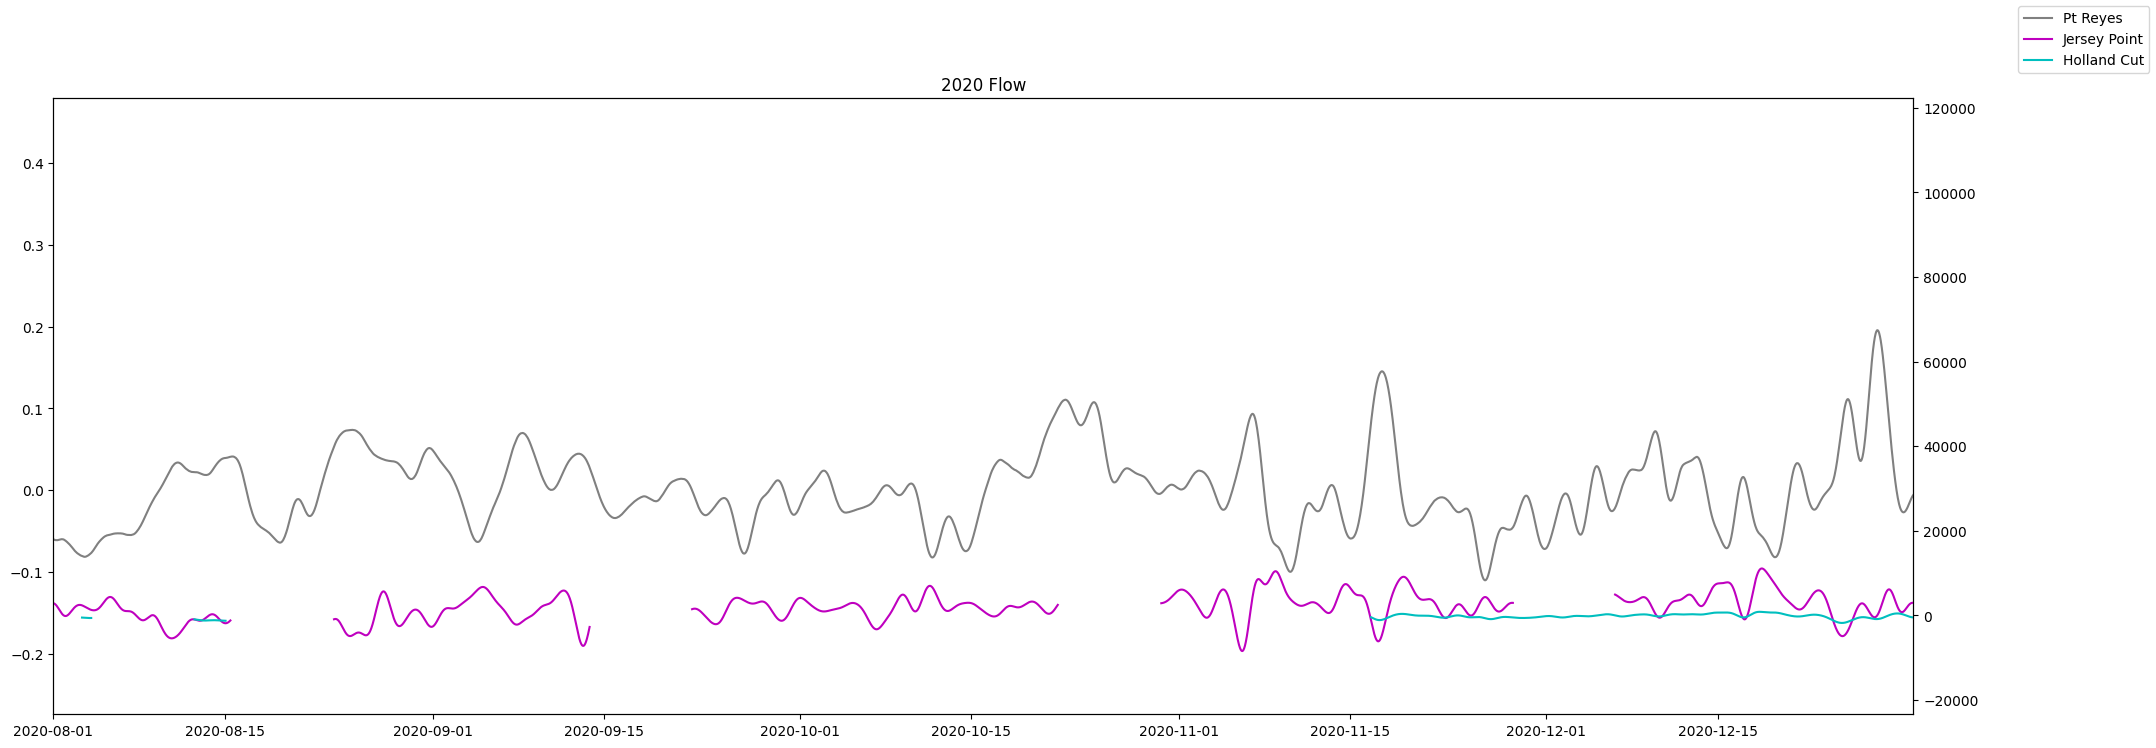

In [7]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(pr_filt.index,pr_filt.Residual,color='grey',label='Pt Reyes')
#ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='m',label='Jersey Point')
#ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
ax1.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='c',label='Holland Cut')
#ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax1.set_xlim([datetime(2020,8,1),datetime(2020,12,31)])
ax.set_title('2020 Flow')
fig.legend()
plt.show()

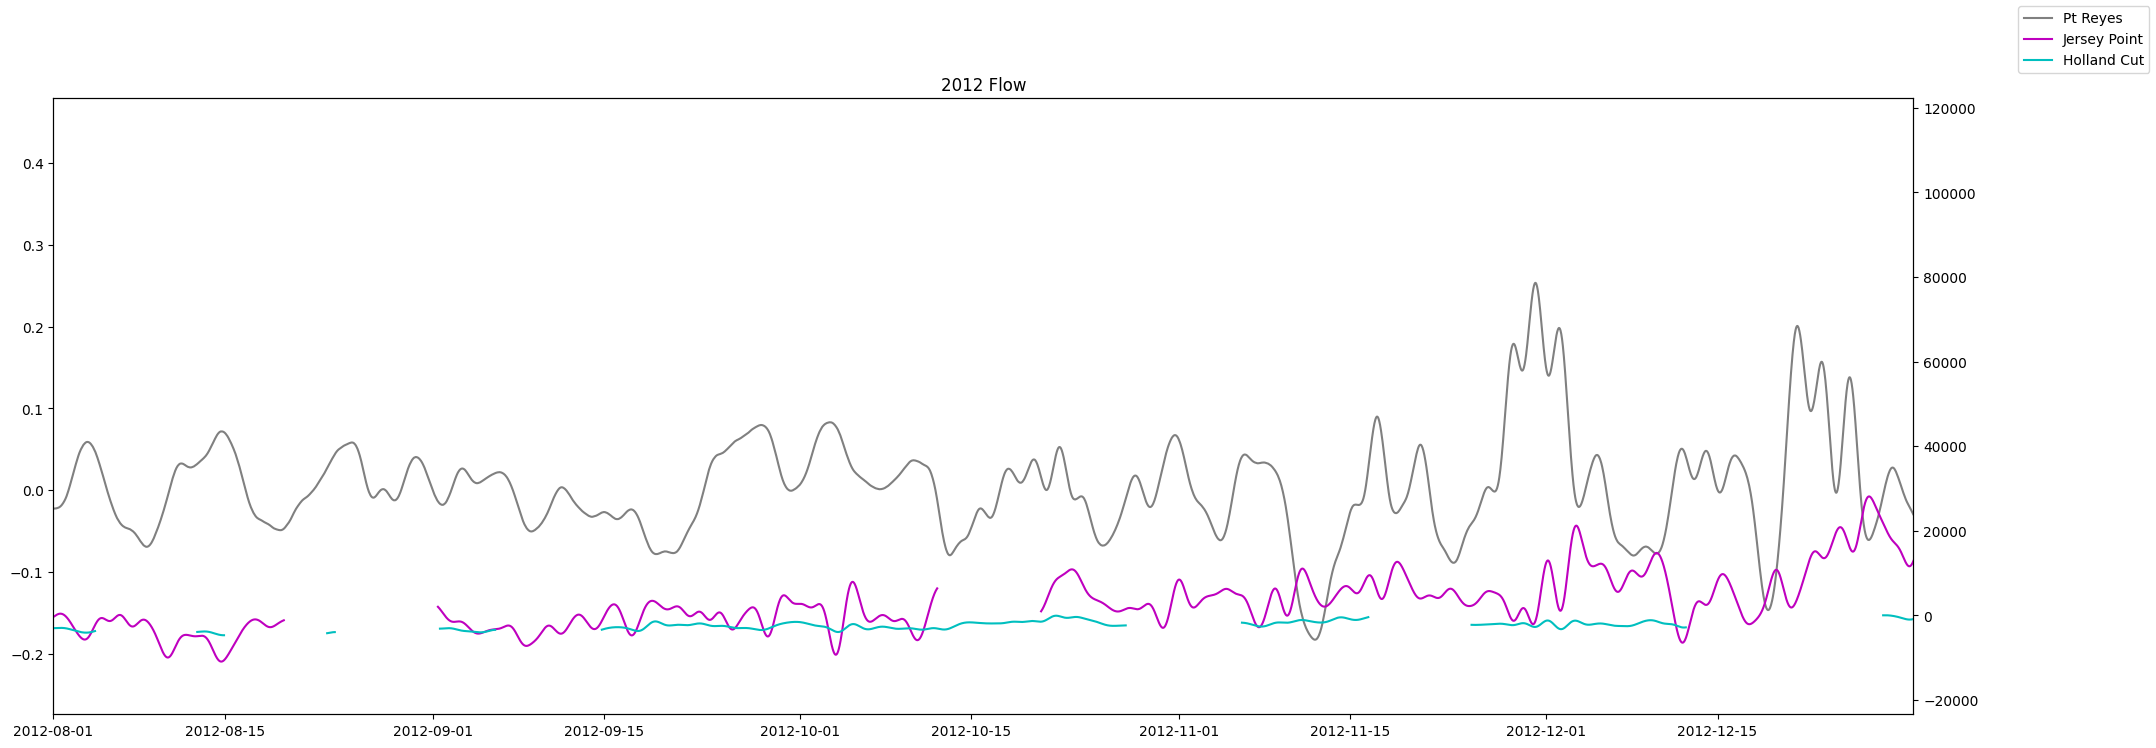

In [8]:
fig, ax =plt.subplots(figsize=(24,8),sharex=True)

ax.plot(pr_filt.index,pr_filt.Residual,color='grey',label='Pt Reyes')
#ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='m',label='Jersey Point')
#ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
#Try plotting on a third axis to see if it makes the peaks at holand cut more visible
ax1.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='c',label='Holland Cut')
#ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax.set_title('2012 Flow')
fig.legend()
plt.show()

# with third y axis

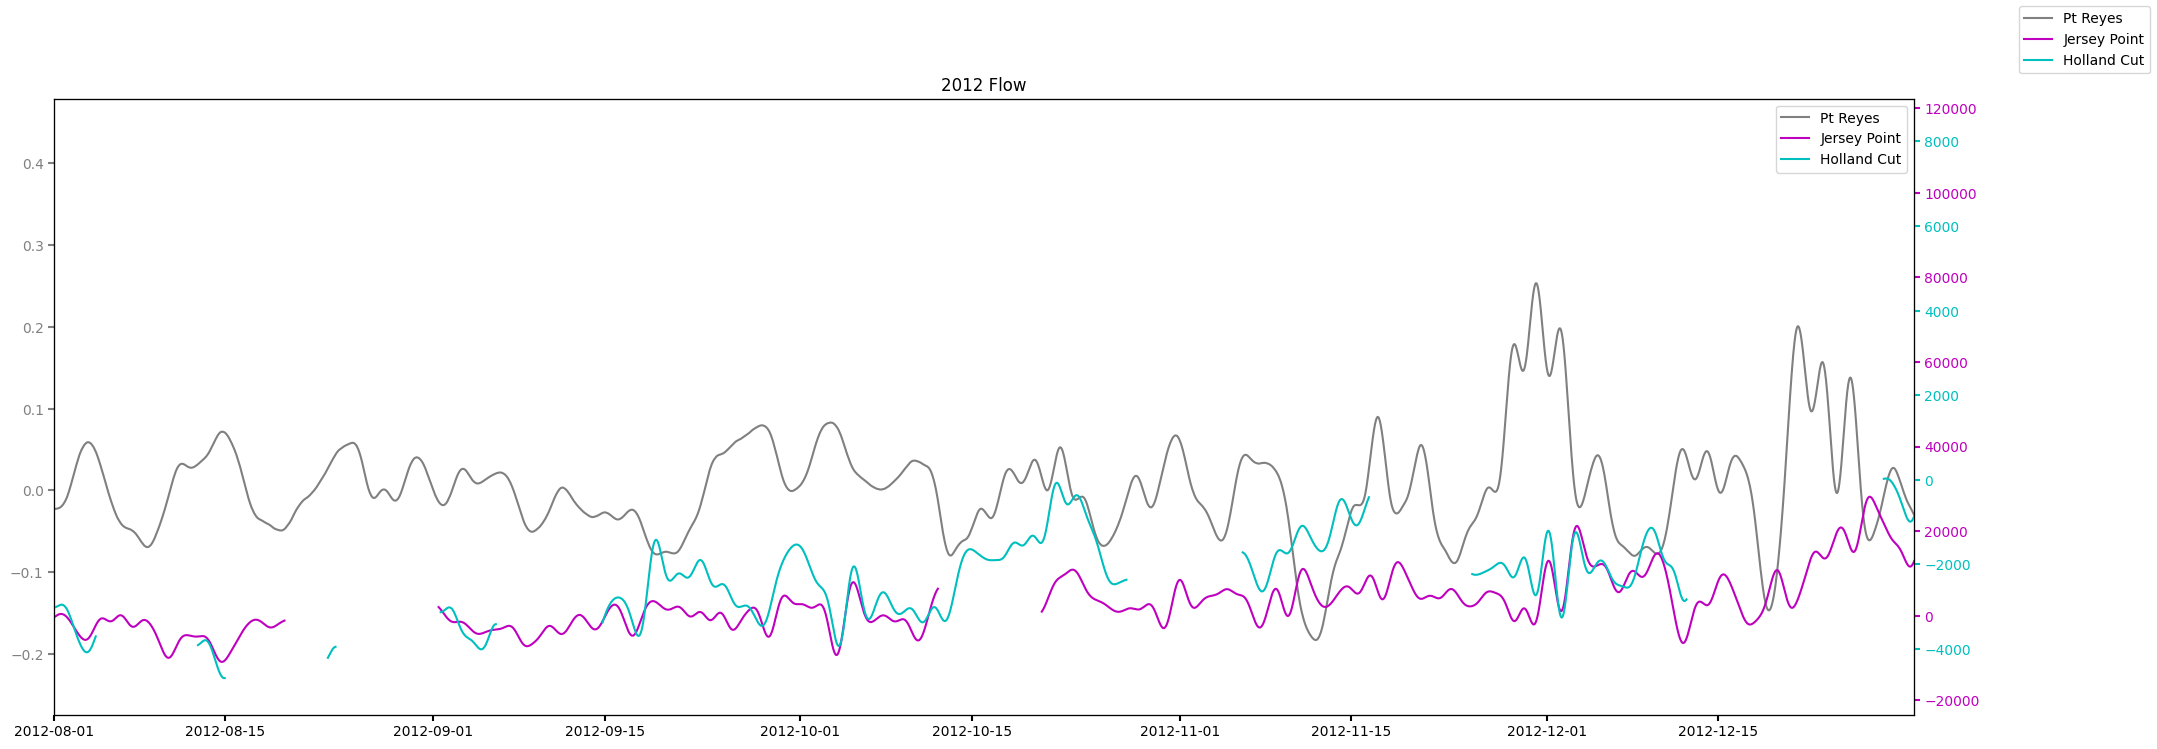

In [9]:
fig, ax =plt.subplots(figsize=(24,8),sharex=True)

p1, =ax.plot(pr_filt.index,pr_filt.Residual,color='grey',label='Pt Reyes')
#ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
p2, =ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='m',label='Jersey Point')
#ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
#Try plotting on a third axis to see if it makes the peaks at holand cut more visible
ax2=ax.twinx()
p3, =ax2.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='c',label='Holland Cut')
#ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,31)])
ax.set_title('2012 Flow')

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])
fig.legend()
plt.show()

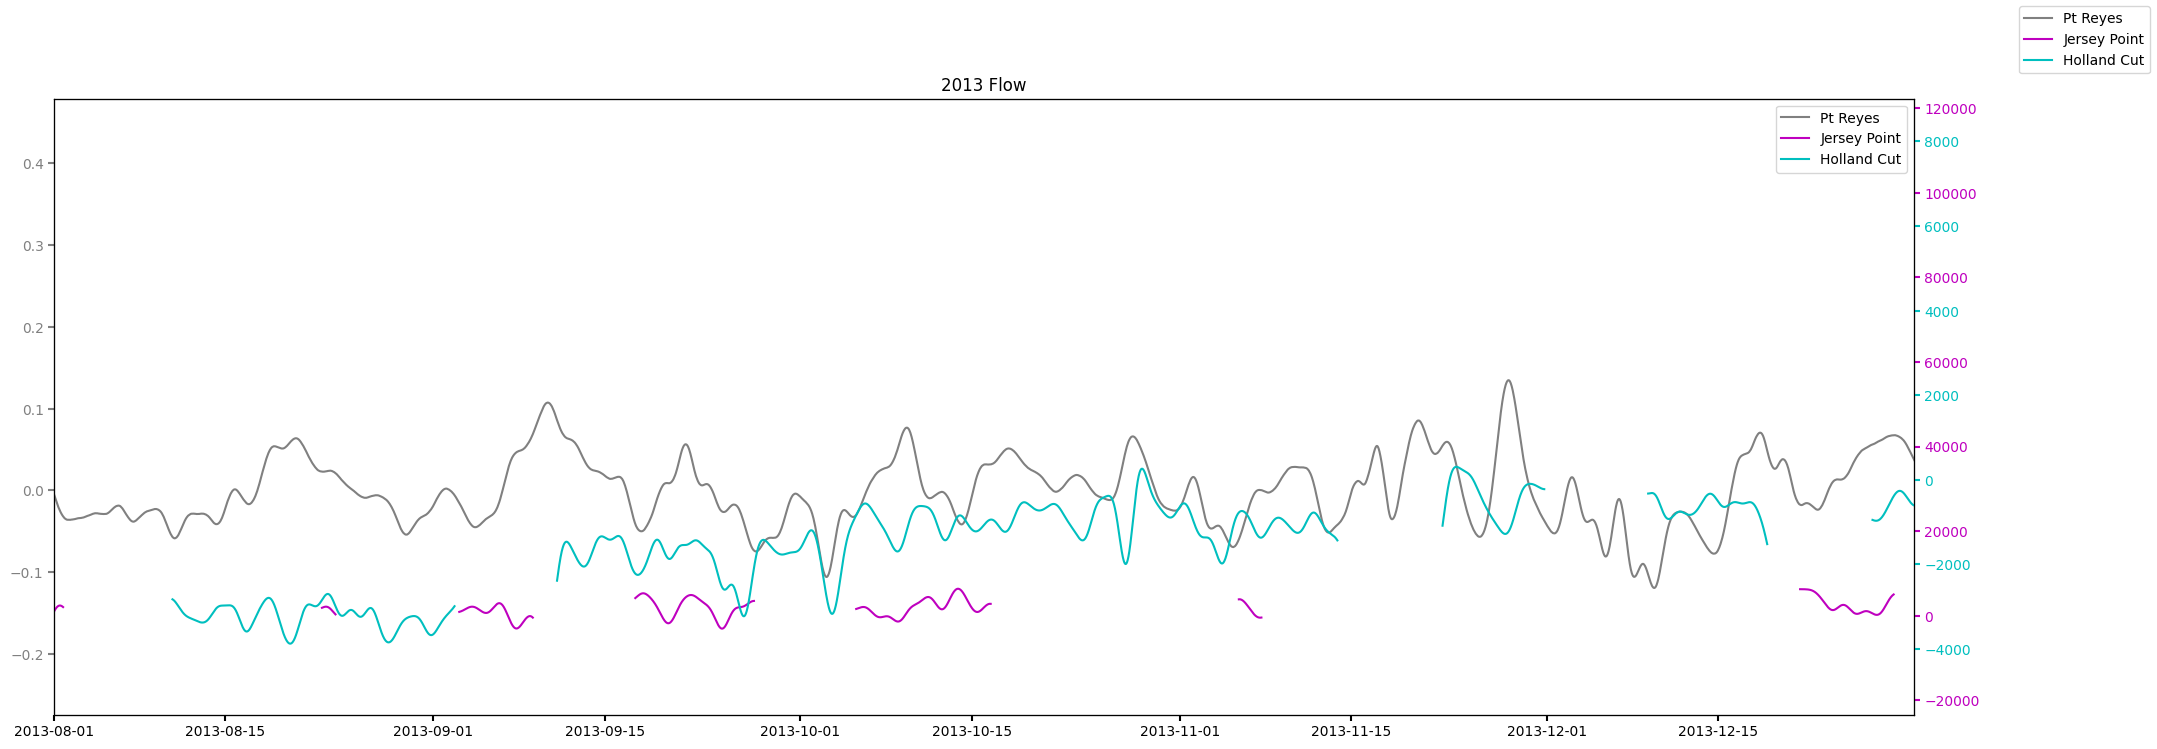

In [10]:
fig, ax =plt.subplots(figsize=(24,8),sharex=True)

p1, =ax.plot(pr_filt.index,pr_filt.Residual,color='grey',label='Pt Reyes')
#ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
p2, =ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='m',label='Jersey Point')
#ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
#Try plotting on a third axis to see if it makes the peaks at holand cut more visible
ax2=ax.twinx()
p3, =ax2.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='c',label='Holland Cut')
#ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2013,8,1),datetime(2013,12,31)])
ax1.set_xlim([datetime(2013,8,1),datetime(2013,12,31)])
ax.set_title('2013 Flow')

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])
fig.legend()
plt.show()

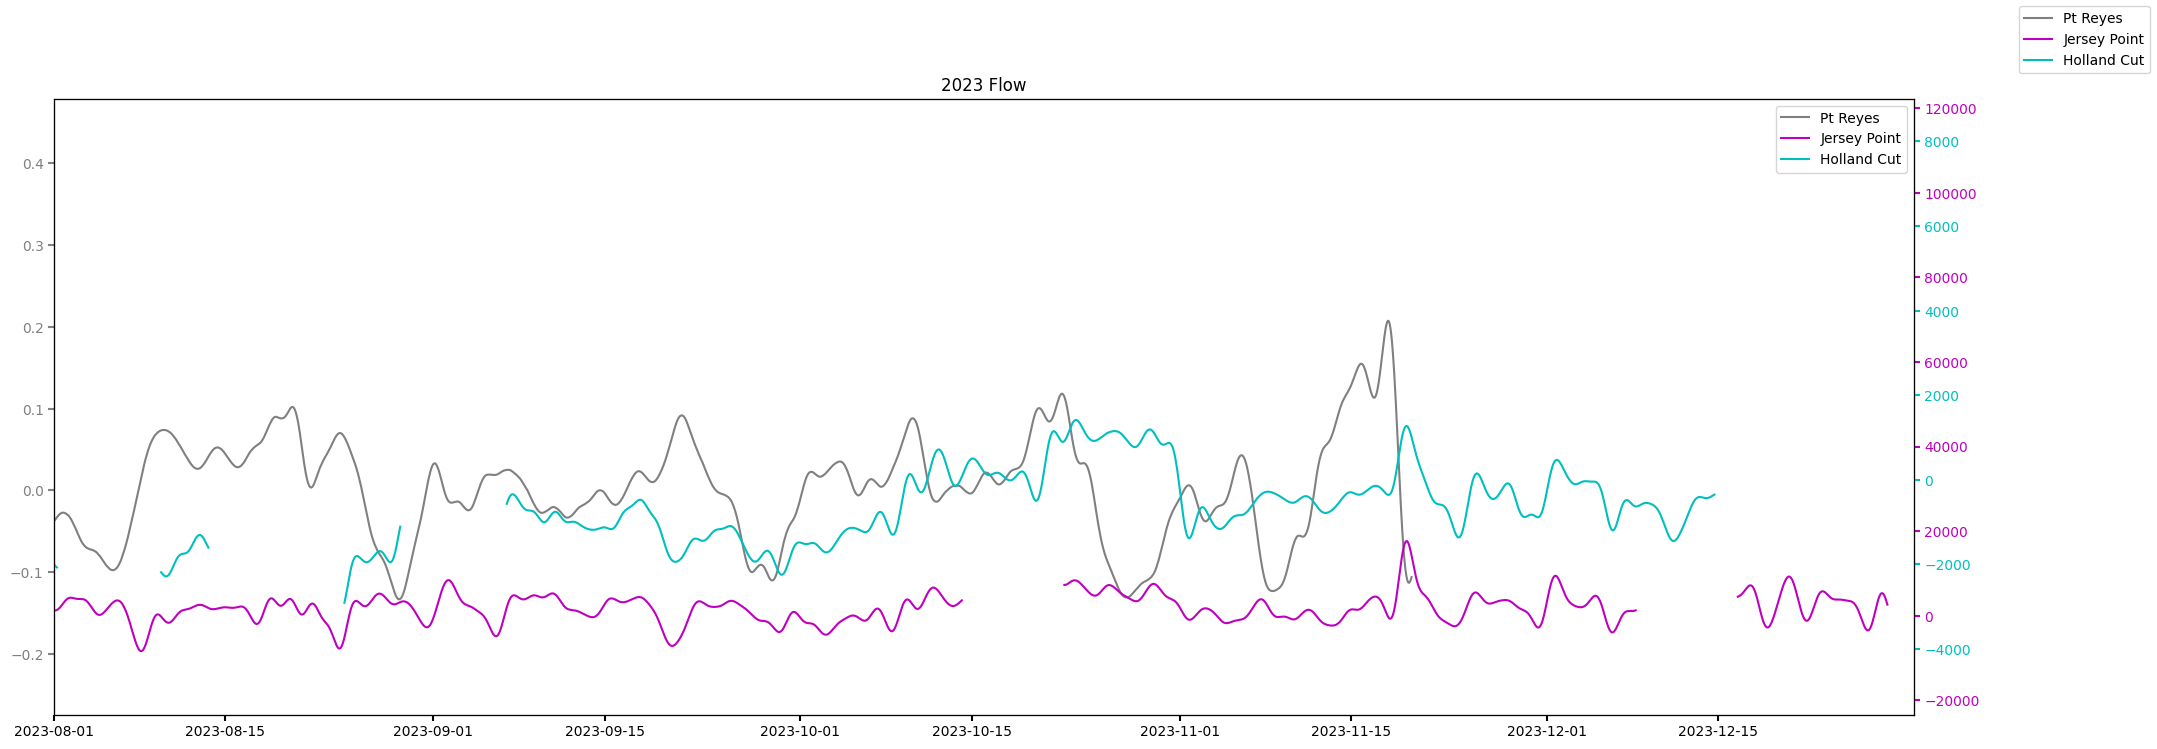

In [11]:
fig, ax =plt.subplots(figsize=(24,8),sharex=True)

p1, =ax.plot(pr_filt.index,pr_filt.Residual,color='grey',label='Pt Reyes')
#ax.scatter(pr_indices[peakspr], df_f_wo21.pr.dropna().iloc[peakspr], label="Point Reyes",marker="x",color='k')
ax1=ax.twinx()
p2, =ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='m',label='Jersey Point')
#ax1.scatter(df_f_wo21.datetime.iloc[peaksjp],df_f_wo21.jp.iloc[peaksjp],label="Jersey Point",marker="x",color='r')
#Try plotting on a third axis to see if it makes the peaks at holand cut more visible
ax2=ax.twinx()
p3, =ax2.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='c',label='Holland Cut')
#ax1.scatter(df_f_wo21.datetime.iloc[peakshol2],df_f_wo21.hol2.iloc[peakshol2],label="Holland Cut",marker="x",color='b')
ax.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
ax1.set_xlim([datetime(2023,8,1),datetime(2023,12,31)])
ax.set_title('2023 Flow')

ax.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])
fig.legend()
plt.show()

# Plot salinity and flow together

(15553.0, 19692.0)

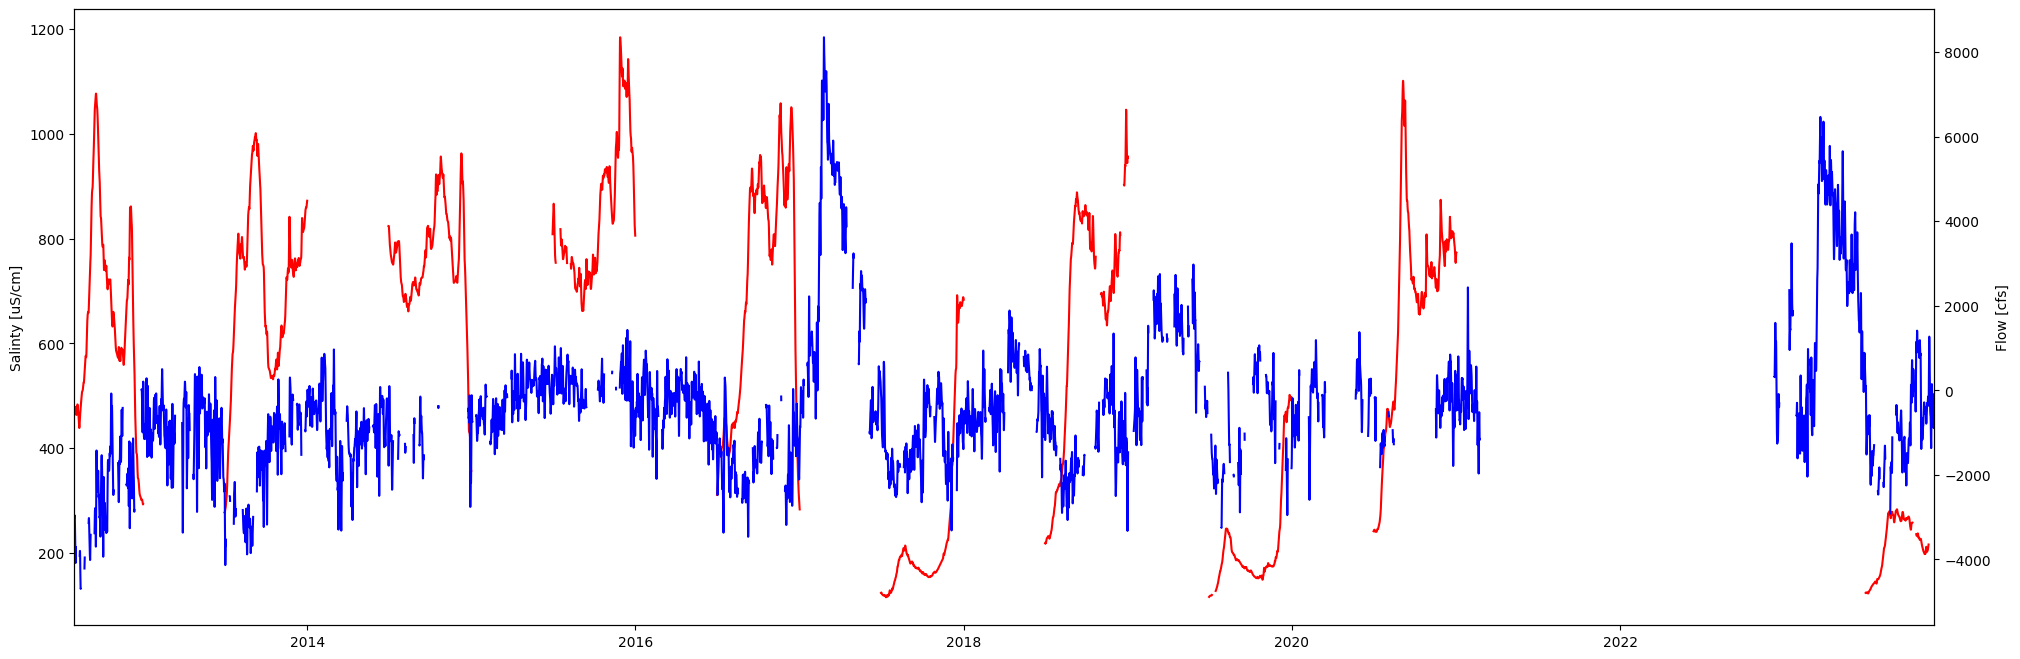

In [12]:
#first just plot Holland cut temp and flow together
fig, ax = plt.subplots(figsize=(24,8),sharex=True)

ax.plot(df_f_wo21.index,df_f_wo21.hol2,color='r',label='Salinity')
ax1=ax.twinx()
ax1.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='b',label='Flow')
ax.set_ylabel('Salinty [uS/cm]')
ax1.set_ylabel('Flow [cfs]')

ax.set_xlim([datetime(2012,8,1),datetime(2023,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2023,12,1)])

(15553.0, 15675.0)

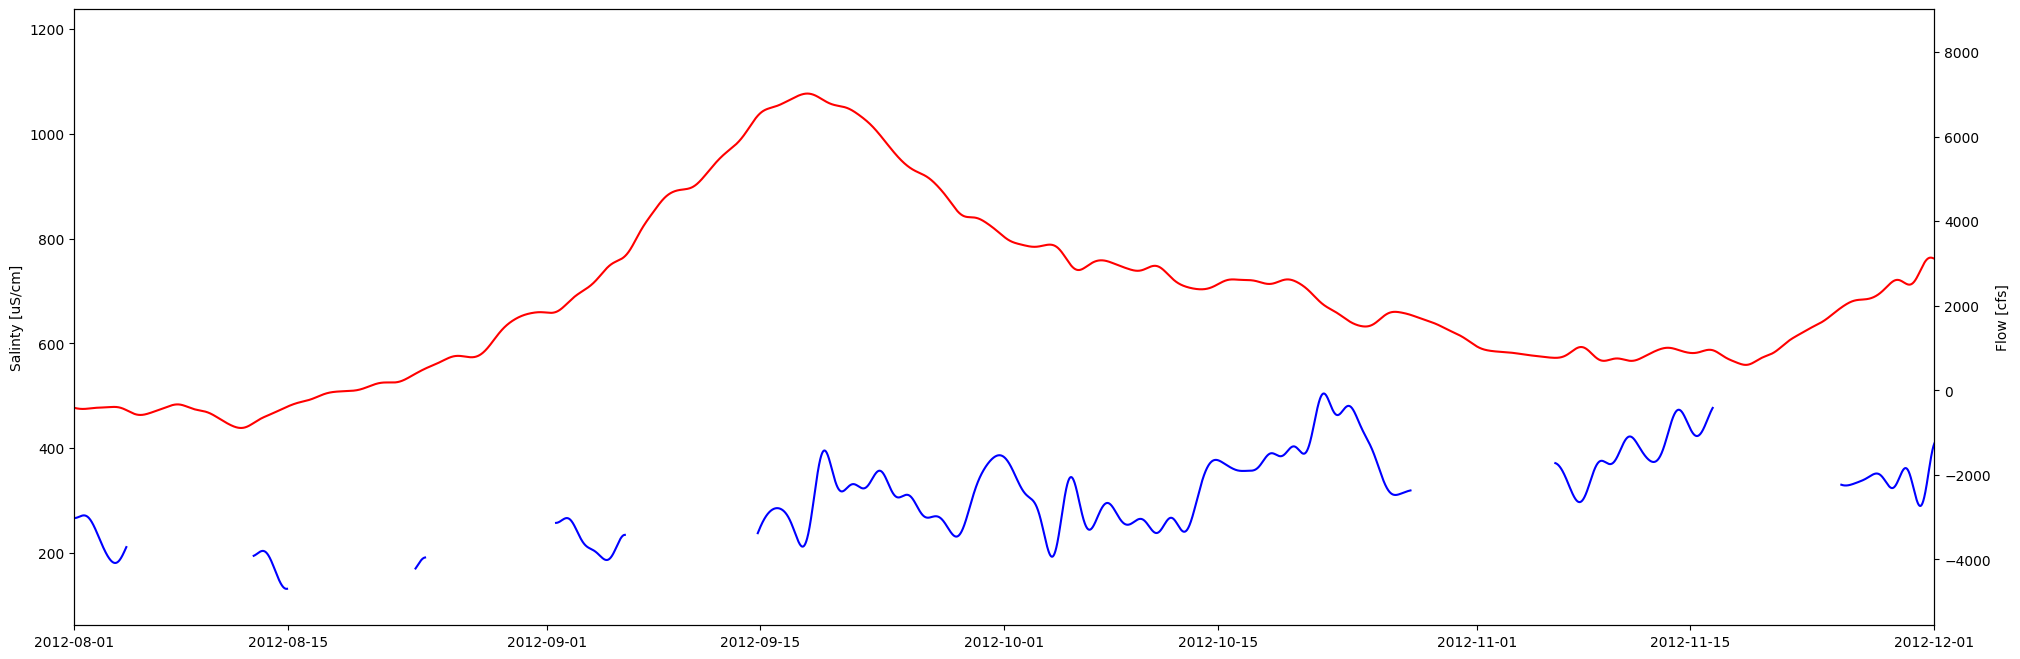

In [17]:
#first just plot Holland cut temp and flow together
fig, ax = plt.subplots(figsize=(24,8),sharex=True)

ax.plot(df_f_wo21.index,df_f_wo21.hol2,color='r',label='Salinity')
ax1=ax.twinx()
ax1.plot(hol2_dms_filt.index,hol2_dms_filt['Flow[cfs]'],color='b',label='Flow')
ax.set_ylabel('Salinty [uS/cm]')
ax1.set_ylabel('Flow [cfs]')

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])

(15553.0, 15675.0)

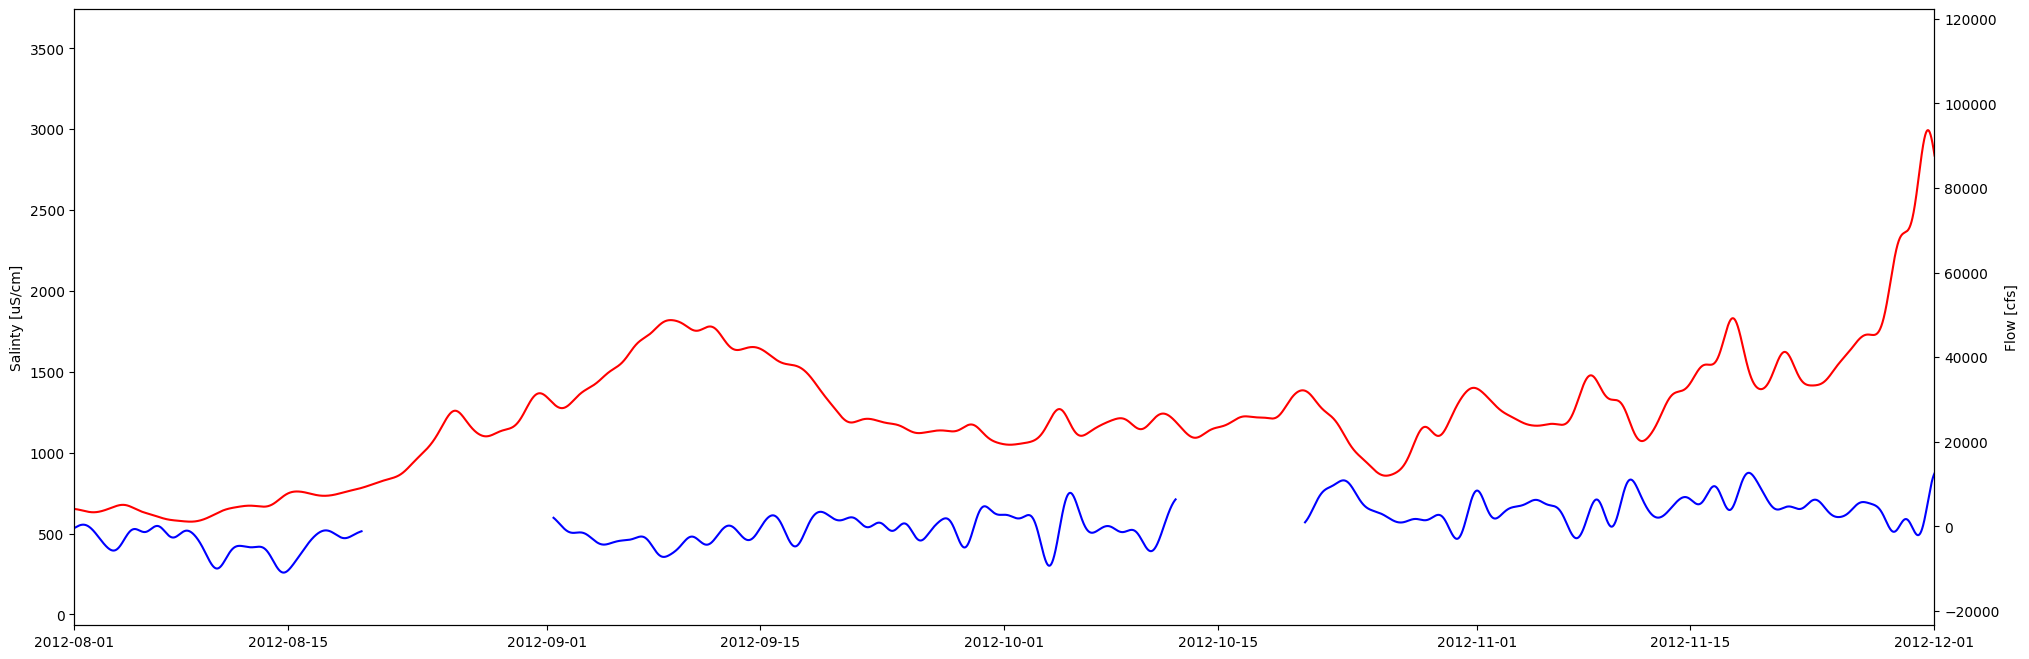

In [16]:
#what about Jersey Point
#first just plot Holland cut temp and flow together
fig, ax = plt.subplots(figsize=(24,8),sharex=True)

ax.plot(df_f_wo21.index,df_f_wo21.jp,color='r',label='Salinity')
ax1=ax.twinx()
ax1.plot(jp_filt.index,jp_filt['Flow[cfs]'],color='b',label='Flow')
ax.set_ylabel('Salinty [uS/cm]')
ax1.set_ylabel('Flow [cfs]')

ax.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2012,12,1)])

# Gap finding

In [29]:
gs=gap_size(sjj_dms) #gives a time series where the value of the time points that don't have data is the length of the gap in minutes
#find the unique values
ug=gs['Flow[cfs]'].unique()
print(sorted(ug))


[0, 15, 30, 45, 60, 75, 120, 135, 150, 165, 180, 210, 225, 240, 270, 285, 300, 315, 330, 345, 450, 480, 525, 540, 555, 570, 750, 810, 1065, 1095, 1140, 1305, 1650, 1695, 1905, 1965, 2325, 2625, 3180, 3315, 3405, 3645, 3750, 4575, 5610, 5790, 6885, 7215, 7365, 8130, 9690, 10470, 10845, 10950, 36150, 298860]


In [27]:
gap_size(sjj_dms)[1985:2010]

,Flow[cfs]
datetime,
2012-01-21 16:15:00,0
2012-01-21 16:30:00,0
2012-01-21 16:45:00,0
2012-01-21 17:00:00,0
2012-01-21 17:15:00,0
2012-01-21 17:30:00,225
2012-01-21 17:45:00,225
2012-01-21 18:00:00,225
2012-01-21 18:15:00,225


In [7]:
#Are there gaps in the sjj signal before it was filtered?
sjj_dropna=sjj_dms.dropna()
sjj_dropna['date_col']=np.array([d.to_datetime64() for d in sjj_dropna.index])
gapmin1=pd.Timedelta('16 min')
mask1=sjj_dropna.date_col.diff().gt(gapmin1)
# get values
starts = sjj_dropna.loc[mask1.shift(-1, fill_value=False), 'date_col'].add(gapmin1).astype(str)
stops = sjj_dropna.loc[mask1, 'date_col'].sub(gapmin1).astype(str)
# build output
out = list(zip(starts, stops))
out

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[('2012-01-21 17:31:00', '2012-01-21 20:59:00'),
 ('2012-02-15 17:31:00', '2012-02-15 19:29:00'),
 ('2012-02-15 20:46:00', '2012-02-15 20:44:00'),
 ('2012-02-15 21:16:00', '2012-02-22 14:29:00'),
 ('2012-04-04 05:16:00', '2012-04-04 07:14:00'),
 ('2012-04-24 10:31:00', '2012-04-25 14:29:00'),
 ('2012-04-27 08:01:00', '2012-04-27 07:59:00'),
 ('2012-06-19 21:01:00', '2012-06-19 22:59:00'),
 ('2012-06-21 08:46:00', '2012-06-21 13:14:00'),
 ('2012-08-24 00:16:00', '2012-08-24 01:59:00'),
 ('2012-08-28 04:16:00', '2012-08-28 05:59:00'),
 ('2012-10-16 09:46:00', '2012-10-16 12:59:00'),
 ('2013-01-14 00:01:00', '2013-01-18 18:29:00'),
 ('2013-04-24 06:46:00', '2013-04-24 11:29:00'),
 ('2013-04-26 14:01:00', '2013-04-26 13:59:00'),
 ('2013-04-26 20:16:00', '2013-04-26 20:14:00'),
 ('2013-06-17 19:31:00', '2013-06-17 21:44:00'),
 ('2013-06-18 02:31:00', '2013-06-18 04:44:00'),
 ('2013-06-18 07:16:00', '2013-06-18 10:59:00'),
 ('2013-06-24 11:46:00', '2013-06-24 11:44:00'),
 ('2013-06-28 10:31:

In [14]:
sjj_dms[1800:2000]

,Flow[cfs]
datetime,
2012-01-19 18:00:00,160000.0
2012-01-19 18:15:00,152000.0
2012-01-19 18:30:00,144000.0
2012-01-19 18:45:00,143000.0
2012-01-19 19:00:00,137000.0
...,...
2012-01-21 18:45:00,NaN
2012-01-21 19:00:00,NaN
2012-01-21 19:15:00,NaN


<AxesSubplot:xlabel='datetime'>

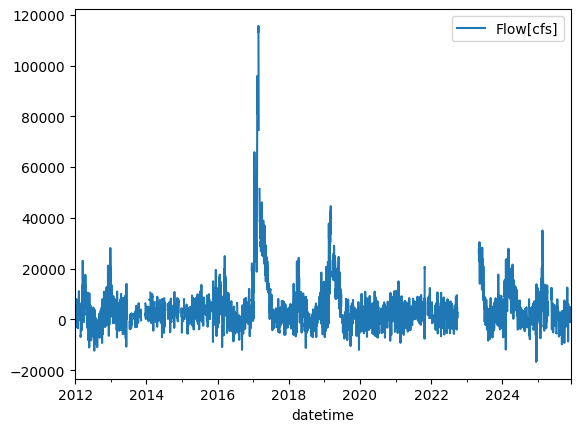

In [5]:
jp_filt.plot()

In [6]:
#what are the time frames of these data?
print("Point Reyes SCHA & BC filt time range: "+str(pr_filt.first_valid_index())+" - "+str(pr_filt.last_valid_index()))
print("Jersey Point time range: "+str(jp_filt.first_valid_index())+" - "+str(jp_filt.last_valid_index()))
print("Holland Cut time range: "+str(hol2_dms_filt.first_valid_index())+" - "+str(hol2_dms_filt.last_valid_index()))

Point Reyes SCHA & BC filt time range: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
Jersey Point time range: 2012-01-05 04:00:00 - 2025-12-01 09:15:00
Holland Cut time range: 2012-01-05 04:00:00 - 2025-09-26 18:45:00


# Compute the cross-correlation to determine the lag

In [7]:
#jersey point signal has gaps, where are the gaps?
jp_trim_downsample=jp_filt['Flow[cfs]'].loc[datetime(2012,2,13):datetime(2023,11,19)].resample('30min').mean().dropna().to_frame() 
#add a column to be the datetime
jp_trim_downsample['date_col']=np.array([d.to_datetime64() for d in jp_trim_downsample.index])
jp_trim_downsample
gapmin=pd.Timedelta('59 min')
mask=jp_trim_downsample.date_col.diff().gt(gapmin)
# get values
starts = jp_trim_downsample.loc[mask.shift(-1, fill_value=False), 'date_col'].add(gapmin).astype(str)
stops = jp_trim_downsample.loc[mask, 'date_col'].sub(gapmin).astype(str)
# build output
out = list(zip(starts, stops))
out

[('2012-03-31 01:59:00', '2012-04-08 10:31:00'),
 ('2012-04-20 06:59:00', '2012-05-01 11:01:00'),
 ('2012-06-15 17:29:00', '2012-06-25 16:31:00'),
 ('2012-08-19 20:59:00', '2012-09-01 09:01:00'),
 ('2012-10-12 06:29:00', '2012-10-20 16:01:00'),
 ('2013-01-09 20:29:00', '2013-01-22 21:31:00'),
 ('2013-04-20 03:29:00', '2013-04-30 23:31:00'),
 ('2013-06-13 15:59:00', '2013-07-13 16:01:00'),
 ('2013-07-19 07:29:00', '2013-07-27 14:01:00'),
 ('2013-08-01 18:29:00', '2013-08-22 20:31:00'),
 ('2013-08-24 00:59:00', '2013-09-03 01:31:00'),
 ('2013-09-09 03:59:00', '2013-09-17 11:01:00'),
 ('2013-09-27 05:29:00', '2013-10-05 12:01:00'),
 ('2013-10-16 13:59:00', '2013-11-05 18:31:00'),
 ('2013-11-07 16:59:00', '2013-12-21 15:31:00'),
 ('2013-12-29 08:59:00', '2014-01-13 20:31:00'),
 ('2014-01-24 09:59:00', '2014-02-01 17:31:00'),
 ('2014-02-02 04:59:00', '2014-02-10 18:31:00'),
 ('2014-03-14 03:59:00', '2014-03-22 11:31:00'),
 ('2014-03-27 07:59:00', '2014-04-04 15:31:00'),
 ('2014-04-07 18:29:

In [8]:
jp_trim_downsample[1500:1600]

,Flow[cfs],date_col
datetime,,
2012-03-29 00:30:00,9449.995869,2012-03-29 00:30:00
2012-03-29 01:00:00,9296.037723,2012-03-29 01:00:00
2012-03-29 01:30:00,9137.558803,2012-03-29 01:30:00
2012-03-29 02:00:00,8975.267310,2012-03-29 02:00:00
2012-03-29 02:30:00,8809.874644,2012-03-29 02:30:00
...,...,...
2012-03-31 00:00:00,-895.353751,2012-03-31 00:00:00
2012-03-31 00:30:00,-933.888012,2012-03-31 00:30:00
2012-03-31 01:00:00,-952.129815,2012-03-31 01:00:00


In [22]:
jp_filt[8640:8650]

,Flow[cfs]
datetime,
2012-03-31 00:00:00,-883.634704
2012-03-31 00:15:00,-907.072799
2012-03-31 00:30:00,-926.363411
2012-03-31 00:45:00,-941.412614
2012-03-31 01:00:00,-952.129815
2012-03-31 01:15:00,NaN
2012-03-31 01:30:00,NaN
2012-03-31 01:45:00,NaN
2012-03-31 02:00:00,NaN


In [23]:
sjj_dms[8640:8650]

,Flow[cfs]
datetime,
2012-03-31 00:00:00,-70300.0
2012-03-31 00:15:00,-67600.0
2012-03-31 00:30:00,-52500.0
2012-03-31 00:45:00,-41300.0
2012-03-31 01:00:00,-33900.0
2012-03-31 01:15:00,-12000.0
2012-03-31 01:30:00,8980.0
2012-03-31 01:45:00,8960.0
2012-03-31 02:00:00,16200.0


<AxesSubplot:xlabel='datetime'>

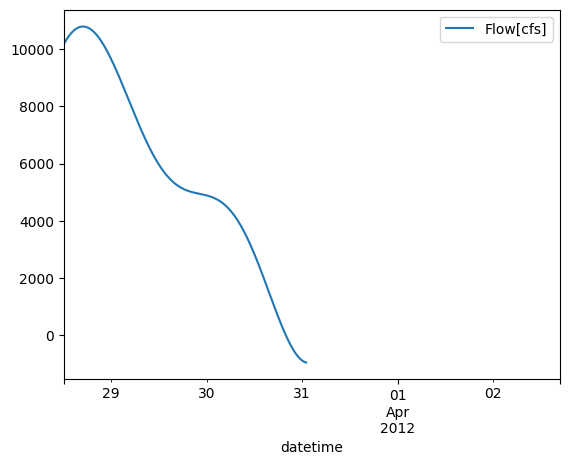

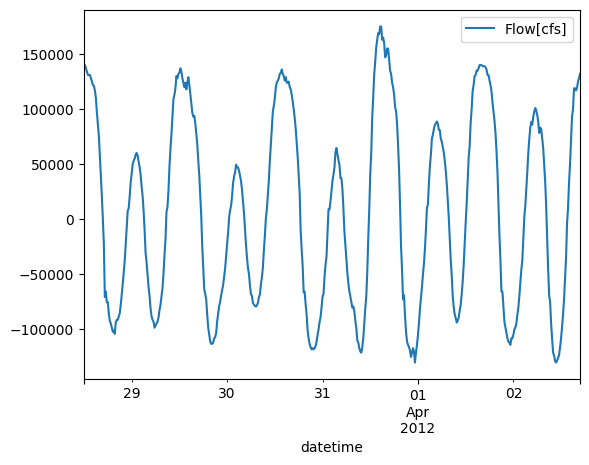

In [28]:
jp_filt[8400:8900].plot()
sjj_dms[8400:8900].plot()

In [ ]:
# #find max lag for 2 periods of time where there are no gaps in salinity signal (a bit under 4 years for each)
# jp_1=jp_filt['Salinity[mS/cm]'].loc[datetime(2013,10,26):datetime(2017,6,30)].resample('30min').mean().values
# pr_1=pr_filt['Residual'].loc[datetime(2013,10,26):datetime(2017,6,30)].values
# jp_2=jp_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2023,4,30)].resample('30min').mean().values
# pr_2=pr_filt['Residual'].loc[datetime(2019,9,25):datetime(2023,4,30)].values

# corr1 = correlate(jp_1,pr_1)
# lags1 = correlation_lags(len(jp_1),len(pr_1))
# corr2 = correlate(jp_2,pr_2)
# lags2 = correlation_lags(len(jp_2),len(pr_2))
# # corr = correlate(jp_f2020, pr_f2020)
# # lags = correlation_lags(len(jp_f2020), len(pr_f2020))
# fig, ax= plt.subplots(1,2,figsize=(24,8))
# ax[0].plot(lags1,corr1)
# ax[0].set_xlabel('Lag (30 min * N)')
# ax[0].set_ylabel('Xcorr')
# ax[0].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 10/26/2013 - 6/30/2017')

# ax[1].plot(lags2,corr2)
# ax[1].set_xlabel('Lag (30 min * N)')
# ax[1].set_ylabel('Xcorr')
# ax[1].set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity, 9/25/2019 - 4/30/2023')
# plt.show()
# print('Lag of max cross-correlation for period 1 is '+ str(lags1[corr1.argmax()]*0.5)+ ' hours')
# print('Lag of max cross-correlation for period 2 is '+ str(lags2[corr2.argmax()]*0.5)+ ' hours')

In [9]:
#find the gaps for holland cut 
hol2_trim=hol2_dms_filt['Flow[cfs]'].loc[datetime(2009,9,4):datetime(2025,8,28)].dropna().to_frame() 
#add a column to be the datetime
hol2_trim['date_col']=np.array([d.to_datetime64() for d in hol2_trim.index])
hol2_trim
gapminsal=pd.Timedelta('16min')
masksal=hol2_trim.date_col.diff().gt(gapminsal)
# get values
startssal = hol2_trim.loc[masksal.shift(-1, fill_value=False), 'date_col'].add(gapminsal).astype(str)
stopssal = hol2_trim.loc[masksal, 'date_col'].sub(gapminsal).astype(str)
# build output
outsal = list(zip(startssal, stopssal))
outsal

[('2012-01-05 14:31:00', '2012-01-15 05:29:00'),
 ('2012-01-15 11:31:00', '2012-01-27 08:44:00'),
 ('2012-01-27 12:16:00', '2012-02-12 10:44:00'),
 ('2012-03-22 00:01:00', '2012-03-30 10:59:00'),
 ('2012-04-19 16:16:00', '2012-04-30 19:29:00'),
 ('2012-08-04 10:01:00', '2012-08-12 17:59:00'),
 ('2012-08-14 23:01:00', '2012-08-23 08:44:00'),
 ('2012-08-24 00:16:00', '2012-09-01 13:59:00'),
 ('2012-09-06 02:46:00', '2012-09-14 19:29:00'),
 ('2012-10-27 15:31:00', '2012-11-06 02:59:00'),
 ('2012-11-16 11:16:00', '2012-11-24 21:14:00'),
 ('2012-12-12 10:01:00', '2012-12-28 12:29:00'),
 ('2013-03-12 22:46:00', '2013-03-28 18:44:00'),
 ('2013-04-14 12:16:00', '2013-04-22 22:14:00'),
 ('2013-07-04 04:31:00', '2013-07-12 15:44:00'),
 ('2013-07-13 09:31:00', '2013-07-21 17:29:00'),
 ('2013-07-25 22:16:00', '2013-08-10 15:59:00'),
 ('2013-09-02 17:46:00', '2013-09-11 02:14:00'),
 ('2013-11-13 21:16:00', '2013-11-22 10:59:00'),
 ('2013-11-30 19:01:00', '2013-12-09 06:14:00'),
 ('2013-12-19 00:16:

In [ ]:
#periods without gaps > 1 yr 
#2012-06-03 2014-01-24 but there are jer gaps here
#2014-02-03 2015-07-07
#2015-08-11 2017-01-06
#2019-07-16 2021-03-19 jer has a gap 2019-09-14 23:31:00', '2019-09-24 00:59:00'
#2019-09-25 2021-03-19
#find max lag for 2 periods of time where there are no gaps in salinity signal (a bit under 4 years for each)
hol2_1=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2014,2,3):datetime(2015,7,7)].values
jp_1=jp_filt['Salinity[mS/cm]'].loc[datetime(2014,2,3):datetime(2015,7,7)].values
hol2_2=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2015,8,11):datetime(2017,1,6)].values
jp_2=jp_filt['Salinity[mS/cm]'].loc[datetime(2015,8,11):datetime(2017,1,6)].values
hol2_3=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2021,3,19)].values
jp_3=jp_filt['Salinity[mS/cm]'].loc[datetime(2019,9,25):datetime(2021,3,19)].values

corr1 = correlate(hol2_1,jp_1)
lags1 = correlation_lags(len(hol2_1),len(jp_1))

corr2 = correlate(hol2_2,jp_2)
lags2 = correlation_lags(len(hol2_2),len(jp_2))

corr3 = correlate(hol2_3,jp_3)
lags3 = correlation_lags(len(hol2_3),len(jp_3))

fig, ax= plt.subplots(1,3,figsize=(24,8))
ax[0].plot(lags1,corr1)
ax[0].set_xlabel('Lag (15 min * N)')
ax[0].set_ylabel('Xcorr')
ax[0].set_title('Cross-correlation v lag , 2/3/2014 - 7/7/2015')

ax[1].plot(lags2,corr2)
ax[1].set_xlabel('Lag (15 min * N)')
ax[1].set_ylabel('Xcorr')
ax[1].set_title('Cross-correlation v lag, 8/11/2015 - 1/6/2017')

ax[2].plot(lags3,corr3)
ax[2].set_xlabel('Lag (15 min * N)')
ax[2].set_ylabel('Xcorr')
ax[2].set_title('Cross-correlation v lag, 9/25/2019 - 3/19/2021')

plt.show()
print('Lag of max cross-correlation for period 1 is '+ str(lags1[corr1.argmax()]*0.25)+ ' hours')
print('Lag of max cross-correlation for period 2 is '+ str(lags2[corr2.argmax()]*0.25)+ ' hours')
print('Lag of max cross-correlation for period 3 is '+ str(lags3[corr3.argmax()]*0.25)+ ' hours')

# What does 2020 look like?